In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/cyclegans_new/pytorch-CycleGAN-and-pix2pix/


/content/drive/.shortcut-targets-by-id/1YdcIEhgBo6PR9UdH-7EpIolvboCvBWrR/cyclegans_new/pytorch-CycleGAN-and-pix2pix


In [4]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 27.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.9 MB/s eta 0:00:00
  Created wheel for visdom: filename=visdom-0.2.4-py3-none-any.whl size=1408195 sh

/content/drive/.shortcut-targets-by-id/1YdcIEhgBo6PR9UdH-7EpIolvboCvBWrR/cyclegans_new/pytorch-CycleGAN-and-pix2pix


/content/drive/.shortcut-targets-by-id/1mxg9bpzF6fUi0fIzXnNhWu0TLFwoQekm/cyclegans


/content/drive/.shortcut-targets-by-id/1mxg9bpzF6fUi0fIzXnNhWu0TLFwoQekm/cyclegans/pytorch-CycleGAN-and-pix2pix


In [7]:
%%writefile models/cycle_gan_model.py
import torch
import itertools
from util.image_pool import ImagePool
from .base_model import BaseModel
from . import networks


class CycleGANModel(BaseModel):
    @staticmethod
    def modify_commandline_options(parser, is_train=True):
        parser.set_defaults(no_dropout=True)
        if is_train:
            parser.add_argument('--lambda_A', type=float, default=10.0, help='weight for cycle loss (A -> B -> A)')
            parser.add_argument('--lambda_B', type=float, default=10.0, help='weight for cycle loss (B -> A -> B)')
            parser.add_argument('--lambda_identity', type=float, default=0.5, help='use identity mapping.')
        return parser

    def __init__(self, opt):
        BaseModel.__init__(self, opt)

        # --- START OF FIX ---
        # Make the model and visual names conditional on whether we are training or testing
        if self.isTrain:
            self.loss_names = ['D_A', 'G_A', 'cycle_A', 'idt_A', 'D_B', 'G_B', 'cycle_B', 'idt_B']
            visual_names_A = ['real_A', 'fake_B', 'rec_A']
            visual_names_B = ['real_B', 'fake_A', 'rec_B']
            if self.opt.lambda_identity > 0.0:
                visual_names_A.append('idt_B')
                visual_names_B.append('idt_A')
            self.visual_names = visual_names_A + visual_names_B
            self.model_names = ['G_A', 'G_B', 'D_A', 'D_B']
        else:  # during test time, only show relevant images and load Gs
            self.visual_names = ['real_A', 'fake_B']
            self.model_names = ['G_A', 'G_B']
        # --- END OF FIX ---

        self.netG_A = networks.define_G(opt.input_nc, opt.output_nc, opt.ngf, opt.netG, opt.norm,
                                        not opt.no_dropout, opt.init_type, opt.init_gain, self.gpu_ids)
        self.netG_B = networks.define_G(opt.output_nc, opt.input_nc, opt.ngf, opt.netG, opt.norm,
                                        not opt.no_dropout, opt.init_type, opt.init_gain, self.gpu_ids)

        if self.isTrain:
            self.netD_A = networks.define_D(opt.output_nc, opt.ndf, opt.netD,
                                            opt.n_layers_D, opt.norm, opt.init_type, opt.init_gain, self.gpu_ids)
            self.netD_B = networks.define_D(opt.input_nc, opt.ndf, opt.netD,
                                            opt.n_layers_D, opt.norm, opt.init_type, opt.init_gain, self.gpu_ids)
            if opt.lambda_identity > 0.0:
                assert(opt.input_nc == opt.output_nc)
            self.fake_A_pool = ImagePool(opt.pool_size)
            self.fake_B_pool = ImagePool(opt.pool_size)
            self.criterionGAN = networks.GANLoss(opt.gan_mode).to(self.device)
            self.criterionCycle = torch.nn.L1Loss()
            self.criterionIdt = torch.nn.L1Loss()
            self.optimizer_G = torch.optim.Adam(itertools.chain(self.netG_A.parameters(), self.netG_B.parameters()), lr=opt.lr, betas=(opt.beta1, 0.999))
            self.optimizer_D = torch.optim.Adam(itertools.chain(self.netD_A.parameters(), self.netD_B.parameters()), lr=opt.lr, betas=(opt.beta1, 0.999))
            self.optimizers.append(self.optimizer_G)
            self.optimizers.append(self.optimizer_D)

    def set_input(self, input):
        AtoB = self.opt.direction == 'AtoB'
        self.real_A = input['A'].to(self.device)
        self.image_paths = input['A_paths']
        if self.isTrain and 'B' in input:
            self.real_B = input['B'].to(self.device)

    def forward(self):
        """Run forward pass"""
        self.fake_B = self.netG_A(self.real_A) # G_A(A)
        # Only compute the rest during training
        if self.isTrain:
            self.rec_A = self.netG_B(self.fake_B)   # G_B(G_A(A))
            self.fake_A = self.netG_B(self.real_B)  # G_B(B)
            self.rec_B = self.netG_A(self.fake_A)   # G_A(G_B(B))

    def backward_D_basic(self, netD, real, fake):
        pred_real = netD(real)
        loss_D_real = self.criterionGAN(pred_real, True)
        pred_fake = netD(fake.detach())
        loss_D_fake = self.criterionGAN(pred_fake, False)
        loss_D = (loss_D_real + loss_D_fake) * 0.5
        loss_D.backward()
        return loss_D

    def backward_D_A(self):
        fake_B = self.fake_B_pool.query(self.fake_B)
        self.loss_D_A = self.backward_D_basic(self.netD_A, self.real_B, fake_B)

    def backward_D_B(self):
        fake_A = self.fake_A_pool.query(self.fake_A)
        self.loss_D_B = self.backward_D_basic(self.netD_B, self.real_A, fake_A)

    def backward_G(self):
        lambda_idt = self.opt.lambda_identity
        lambda_A = self.opt.lambda_A
        lambda_B = self.opt.lambda_B
        if lambda_idt > 0:
            self.idt_A = self.netG_A(self.real_B)
            self.loss_idt_A = self.criterionIdt(self.idt_A, self.real_B) * lambda_B * lambda_idt
            self.idt_B = self.netG_B(self.real_A)
            self.loss_idt_B = self.criterionIdt(self.idt_B, self.real_A) * lambda_A * lambda_idt
        else:
            self.loss_idt_A = 0
            self.loss_idt_B = 0
        self.loss_G_A = self.criterionGAN(self.netD_A(self.fake_B), True)
        self.loss_G_B = self.criterionGAN(self.netD_B(self.fake_A), True)
        self.loss_cycle_A = self.criterionCycle(self.rec_A, self.real_A) * lambda_A
        self.loss_cycle_B = self.criterionCycle(self.rec_B, self.real_B) * lambda_B
        self.loss_G = self.loss_G_A + self.loss_G_B + self.loss_cycle_A + self.loss_cycle_B + self.loss_idt_A + self.loss_idt_B
        self.loss_G.backward()

    def optimize_parameters(self):
        self.forward()
        self.set_requires_grad([self.netD_A, self.netD_B], False)
        self.optimizer_G.zero_grad()
        self.backward_G()
        self.optimizer_G.step()
        self.set_requires_grad([self.netD_A, self.netD_B], True)
        self.optimizer_D.zero_grad()
        self.backward_D_A()
        self.backward_D_B()
        self.optimizer_D.step()

Overwriting models/cycle_gan_model.py


In [8]:
%%writefile data/__init__.py
import importlib, torch.utils.data
from data.base_dataset import BaseDataset
def find_dataset_using_name(dataset_name):
    # Add our custom datasets to the search path
    if dataset_name == 'unaligned_npy': from data.unaligned_npy_dataset import UnalignedNpyDataset as dataset
    elif dataset_name == 'single_npy': from data.single_npy_dataset import SingleNpyDataset as dataset
    else:
        dataset_filename = "data." + dataset_name + "_dataset"
        datasetlib = importlib.import_module(dataset_filename)
        dataset = None
        target_dataset_name = dataset_name.replace('_', '') + 'dataset'
        for name, cls in datasetlib.__dict__.items():
            if name.lower() == target_dataset_name.lower() and issubclass(cls, BaseDataset): dataset = cls
    if dataset is None: raise NotImplementedError("Dataset class not found for '%s'" % dataset_name)
    return dataset
def get_option_setter(dataset_name):
    dataset_class = find_dataset_using_name(dataset_name)
    return dataset_class.modify_commandline_options
def create_dataset(opt):
    data_loader = CustomDatasetDataLoader(opt)
    return data_loader.load_data()
class CustomDatasetDataLoader():
    def __init__(self, opt):
        self.opt = opt
        dataset_class = find_dataset_using_name(opt.dataset_mode)
        self.dataset = dataset_class(opt)
        print("dataset [%s] was created" % type(self.dataset).__name__)
        self.dataloader = torch.utils.data.DataLoader(self.dataset, batch_size=opt.batch_size, shuffle=not opt.serial_batches, num_workers=int(opt.num_threads))
    def load_data(self): return self
    def __len__(self): return len(self.dataset)
    def __iter__(self):
        for i, data in enumerate(self.dataloader): yield data

print("✅ Dataloader files for .npy format have been created/patched.")

Overwriting data/__init__.py


In [9]:
%%writefile data/single_npy_dataset.py
import os, torch, numpy as np
from data.base_dataset import BaseDataset
class SingleNpyDataset(BaseDataset):
    def __init__(self, opt):
        BaseDataset.__init__(self, opt)
        self.A_paths = sorted([os.path.join(opt.dataroot, f) for f in os.listdir(opt.dataroot) if f.endswith('.npy')])
    def __getitem__(self, index):
        A_path = self.A_paths[index]
        A_npy = np.load(A_path).astype(np.float32)
        A_tensor = torch.from_numpy(A_npy.transpose((2, 0, 1)))
        return {'A': A_tensor, 'A_paths': A_path}
    def __len__(self):
        return len(self.A_paths)

# Update __init__.py to recognize the new dataloader


Overwriting data/single_npy_dataset.py


In [ ]:
# --- ⚙️ CONFIGURATION ---
# 1. The name of your new training experiment folder.
EXPERIMENT_NAME = 'sar2rgb_perceptual'

# 2. The epoch number you want to evaluate.
EPOCH_TO_TEST = '10'

# 3. The generator architecture you used for training.
NET_G = 'resnet_9blocks'
# --- END CONFIGURATION ---

# Navigate to the project directory first
%cd /content/drive/MyDrive/cyclegans/pytorch-CycleGAN-and-pix2pix/

# Construct and run the test command
!python test.py \
  --dataroot "/content/drive/MyDrive/cyclegans/pytorch-CycleGAN-and-pix2pix/preprocessed_test_data/sar_input" \
  --name {EXPERIMENT_NAME} \
  --model cycle_gan \
  --netG {NET_G} \
  --dataset_mode single_npy \
  --input_nc 2 \
  --output_nc 3 \
  --no_flip \
  --epoch {EPOCH_TO_TEST} \
  --eval \
  --num_test 400


/content/drive/.shortcut-targets-by-id/1mxg9bpzF6fUi0fIzXnNhWu0TLFwoQekm/cyclegans/pytorch-CycleGAN-and-pix2pix
✅ Dataloader files for .npy format have been created/patched.
----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: /content/drive/MyDrive/cyclegans/pytorch-CycleGAN-and-pix2pix/preprocessed_test_data/sar_input	[default: None]
             dataset_mode: single_npy                    	[default: unaligned]
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: 10                            	[default: latest]
                     eval: True                          	[default: False]
                  gpu_ids: 0                             
          

ls: cannot access './checkpoints/sar2rgb_winter_colab/10_net_G_A.pth': No such file or directory


test_opt.txt


/content/drive/.shortcut-targets-by-id/1YdcIEhgBo6PR9UdH-7EpIolvboCvBWrR/cyclegans_new/pytorch-CycleGAN-and-pix2pix


Overwriting evaluate.py


Overwriting evaluate.py


In [ ]:
%cd /content/drive/MyDrive/cyclegans_new/pytorch-CycleGAN-and-pix2pix

/content/drive/.shortcut-targets-by-id/1YdcIEhgBo6PR9UdH-7EpIolvboCvBWrR/cyclegans_new/pytorch-CycleGAN-and-pix2pix


In [ ]:
# --- ⚙️ CONFIGURATION ---
# 1. The name of your new training experiment folder.
EXPERIMENT_NAME = 'sar2rgb_perceptual'

# 2. The epoch number you want to evaluate.
EPOCH_TO_TEST = 'latest'

# 3. The generator architecture you used for training.
NET_G = 'resnet_9blocks'
# --- END CONFIGURATION ---

# Navigate to the project directory first
%cd /content/drive/MyDrive/cyclegans_new/pytorch-CycleGAN-and-pix2pix/

# Construct and run the test command
!python test.py \
  --dataroot "/content/drive/MyDrive/cyclegans/pytorch-CycleGAN-and-pix2pix/preprocessed_test_data/sar_input" \
  --name {EXPERIMENT_NAME} \
  --model cycle_gan \
  --netG {NET_G} \
  --dataset_mode single_npy \
  --input_nc 2 \
  --output_nc 3 \
  --no_flip \
  --epoch {EPOCH_TO_TEST} \
  --eval \
  --num_test 400


/content/drive/.shortcut-targets-by-id/1YdcIEhgBo6PR9UdH-7EpIolvboCvBWrR/cyclegans_new/pytorch-CycleGAN-and-pix2pix
✅ Dataloader files for .npy format have been created/patched.
----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: /content/drive/MyDrive/cyclegans/pytorch-CycleGAN-and-pix2pix/preprocessed_test_data/sar_input	[default: None]
             dataset_mode: single_npy                    	[default: unaligned]
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: True                          	[default: False]
                  gpu_ids: 0                             
                init_gai

Overwriting evaluate.py


In [ ]:
!python evaluate.py

Found 400 generated images. Starting evaluation...
Evaluating Images: 100% 400/400 [00:18<00:00, 21.80it/s]

--- Final Evaluation Results ---
Epoch Tested: 10
Images Evaluated: 400
Average SSIM: 0.4984 (Closer to 1 is better)
Average PSNR: 18.0490 dB (Higher is better)
--------------------------------


In [26]:
# --- ⚙️ CONFIGURATION ---
# 1. The name of your new training experiment folder.
EXPERIMENT_NAME = 'sar2rgb_perceptual'

# 2. The epoch number you want to evaluate.
EPOCH_TO_TEST = '15'

# 3. The generator architecture you used for training.
NET_G = 'resnet_9blocks'
# --- END CONFIGURATION ---

# Navigate to the project directory first
%cd /content/drive/MyDrive/cyclegans_new/pytorch-CycleGAN-and-pix2pix/

# Construct and run the test command
!python test.py \
  --dataroot "/content/drive/MyDrive/cyclegans_new/pytorch-CycleGAN-and-pix2pix/test_data/sar_input" \
  --name {EXPERIMENT_NAME} \
  --model cycle_gan \
  --netG {NET_G} \
  --dataset_mode single_npy \
  --input_nc 2 \
  --output_nc 3 \
  --no_flip \
  --epoch {EPOCH_TO_TEST} \
  --eval


/content/drive/.shortcut-targets-by-id/1YdcIEhgBo6PR9UdH-7EpIolvboCvBWrR/cyclegans_new/pytorch-CycleGAN-and-pix2pix
✅ Dataloader files for .npy format have been created/patched.
----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: /content/drive/MyDrive/cyclegans_new/pytorch-CycleGAN-and-pix2pix/test_data/sar_input	[default: None]
             dataset_mode: single_npy                    	[default: unaligned]
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: 15                            	[default: latest]
                     eval: True                          	[default: False]
                  gpu_ids: 0                             
               

In [27]:
%%writefile evaluate.py
import os
import cv2
import numpy as np
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# --- Configuration ---
EPOCH_TO_EVALUATE = '15'
EXPERIMENT_NAME = 'sar2rgb_perceptual'
GENERATED_DIR = f"./results/{EXPERIMENT_NAME}/test_{EPOCH_TO_EVALUATE}/images/"
GROUND_TRUTH_DIR = "/content/drive/MyDrive/cyclegans_new/pytorch-CycleGAN-and-pix2pix/test_data/eo_ground_truth_rgb"
# ---

def evaluate_model(generated_dir, ground_truth_dir):
    if not os.path.exists(generated_dir):
        print(f"❌ Error: Generated images directory not found at '{generated_dir}'")
        return

    # test.py saves images with a _fake_B.png suffix for CycleGAN
    generated_files = [f for f in os.listdir(generated_dir) if f.endswith('_fake_B.png')]
    if not generated_files:
        print(f"❌ Error: Found 0 images with the '_fake_B.png' suffix in '{generated_dir}'. Please check the folder and filenames.")
        return

    print(f"Found {len(generated_files)} generated images. Starting evaluation...")
    psnr_scores, ssim_scores = [], []

    for fname in tqdm(generated_files, desc="Evaluating Images"):
        generated_path = os.path.join(generated_dir, fname)
        generated_image = cv2.cvtColor(cv2.imread(generated_path), cv2.COLOR_BGR2RGB)

        # Construct the corresponding ground truth filename
        gt_fname = fname.replace('_s1_', '_s2_').replace('_fake_B.png', '.npy')
        gt_path = os.path.join(ground_truth_dir, gt_fname)

        if os.path.exists(gt_path):
            gt_npy = np.load(gt_path)
            # De-normalize from [-1, 1] to [0, 255]
            gt_image = ((gt_npy + 1) / 2.0 * 255.0).astype(np.uint8)

            # Calculate metrics
            current_ssim = ssim(gt_image, generated_image, channel_axis=2, data_range=255)
            current_psnr = psnr(gt_image, generated_image, data_range=255)
            ssim_scores.append(current_ssim)
            psnr_scores.append(current_psnr)

    if ssim_scores:
        print("\n--- Final Evaluation Results ---")
        print(f"Epoch Tested: {EPOCH_TO_EVALUATE}")
        print(f"Images Evaluated: {len(ssim_scores)}")
        print(f"Average SSIM: {np.mean(ssim_scores):.4f} (Closer to 1 is better)")
        print(f"Average PSNR: {np.mean(psnr_scores):.4f} dB (Higher is better)")
        print("--------------------------------")

if __name__ == "__main__":
    evaluate_model(GENERATED_DIR, GROUND_TRUTH_DIR)

Overwriting evaluate.py


In [28]:
!python evaluate.py

Found 50 generated images. Starting evaluation...
Evaluating Images: 100% 50/50 [00:02<00:00, 22.88it/s]

--- Final Evaluation Results ---
Epoch Tested: 15
Images Evaluated: 50
Average SSIM: 0.5717 (Closer to 1 is better)
Average PSNR: 20.7622 dB (Higher is better)
--------------------------------


In [ ]:
!python evaluate.py

Found 446 generated images. Starting evaluation...
Evaluating Images: 100% 446/446 [00:23<00:00, 18.75it/s]

--- Final Evaluation Results ---
Epoch Tested: 5
Images Evaluated: 400
Average SSIM: 0.5109 (Closer to 1 is better)
Average PSNR: 20.0870 dB (Higher is better)
--------------------------------


In [ ]:
!python evaluate.py

Found 400 generated images. Starting evaluation...
Evaluating Images: 100% 400/400 [00:18<00:00, 21.32it/s]

--- Final Evaluation Results ---
Epoch Tested: latest
Images Evaluated: 400
Average SSIM: 0.5612 (Closer to 1 is better)
Average PSNR: 19.5543 dB (Higher is better)
--------------------------------


In [ ]:
!python evaluate.py

Found 400 generated images. Starting evaluation...
Evaluating Images: 100% 400/400 [00:18<00:00, 21.47it/s]

--- Final Evaluation Results ---
Epoch Tested: 10
Images Evaluated: 400
Average SSIM: 0.4854 (Closer to 1 is better)
Average PSNR: 18.7006 dB (Higher is better)
--------------------------------


In [ ]:
!python evaluate.py

Found 400 generated images. Starting evaluation...
Evaluating Images: 100% 400/400 [02:37<00:00,  2.53it/s]

--- Final Evaluation Results ---
Epoch Tested: 20
Images Evaluated: 400
Average SSIM: 0.5151 (Closer to 1 is better)
Average PSNR: 17.6797 dB (Higher is better)
--------------------------------


Successfully parsed 664 records from the log file.


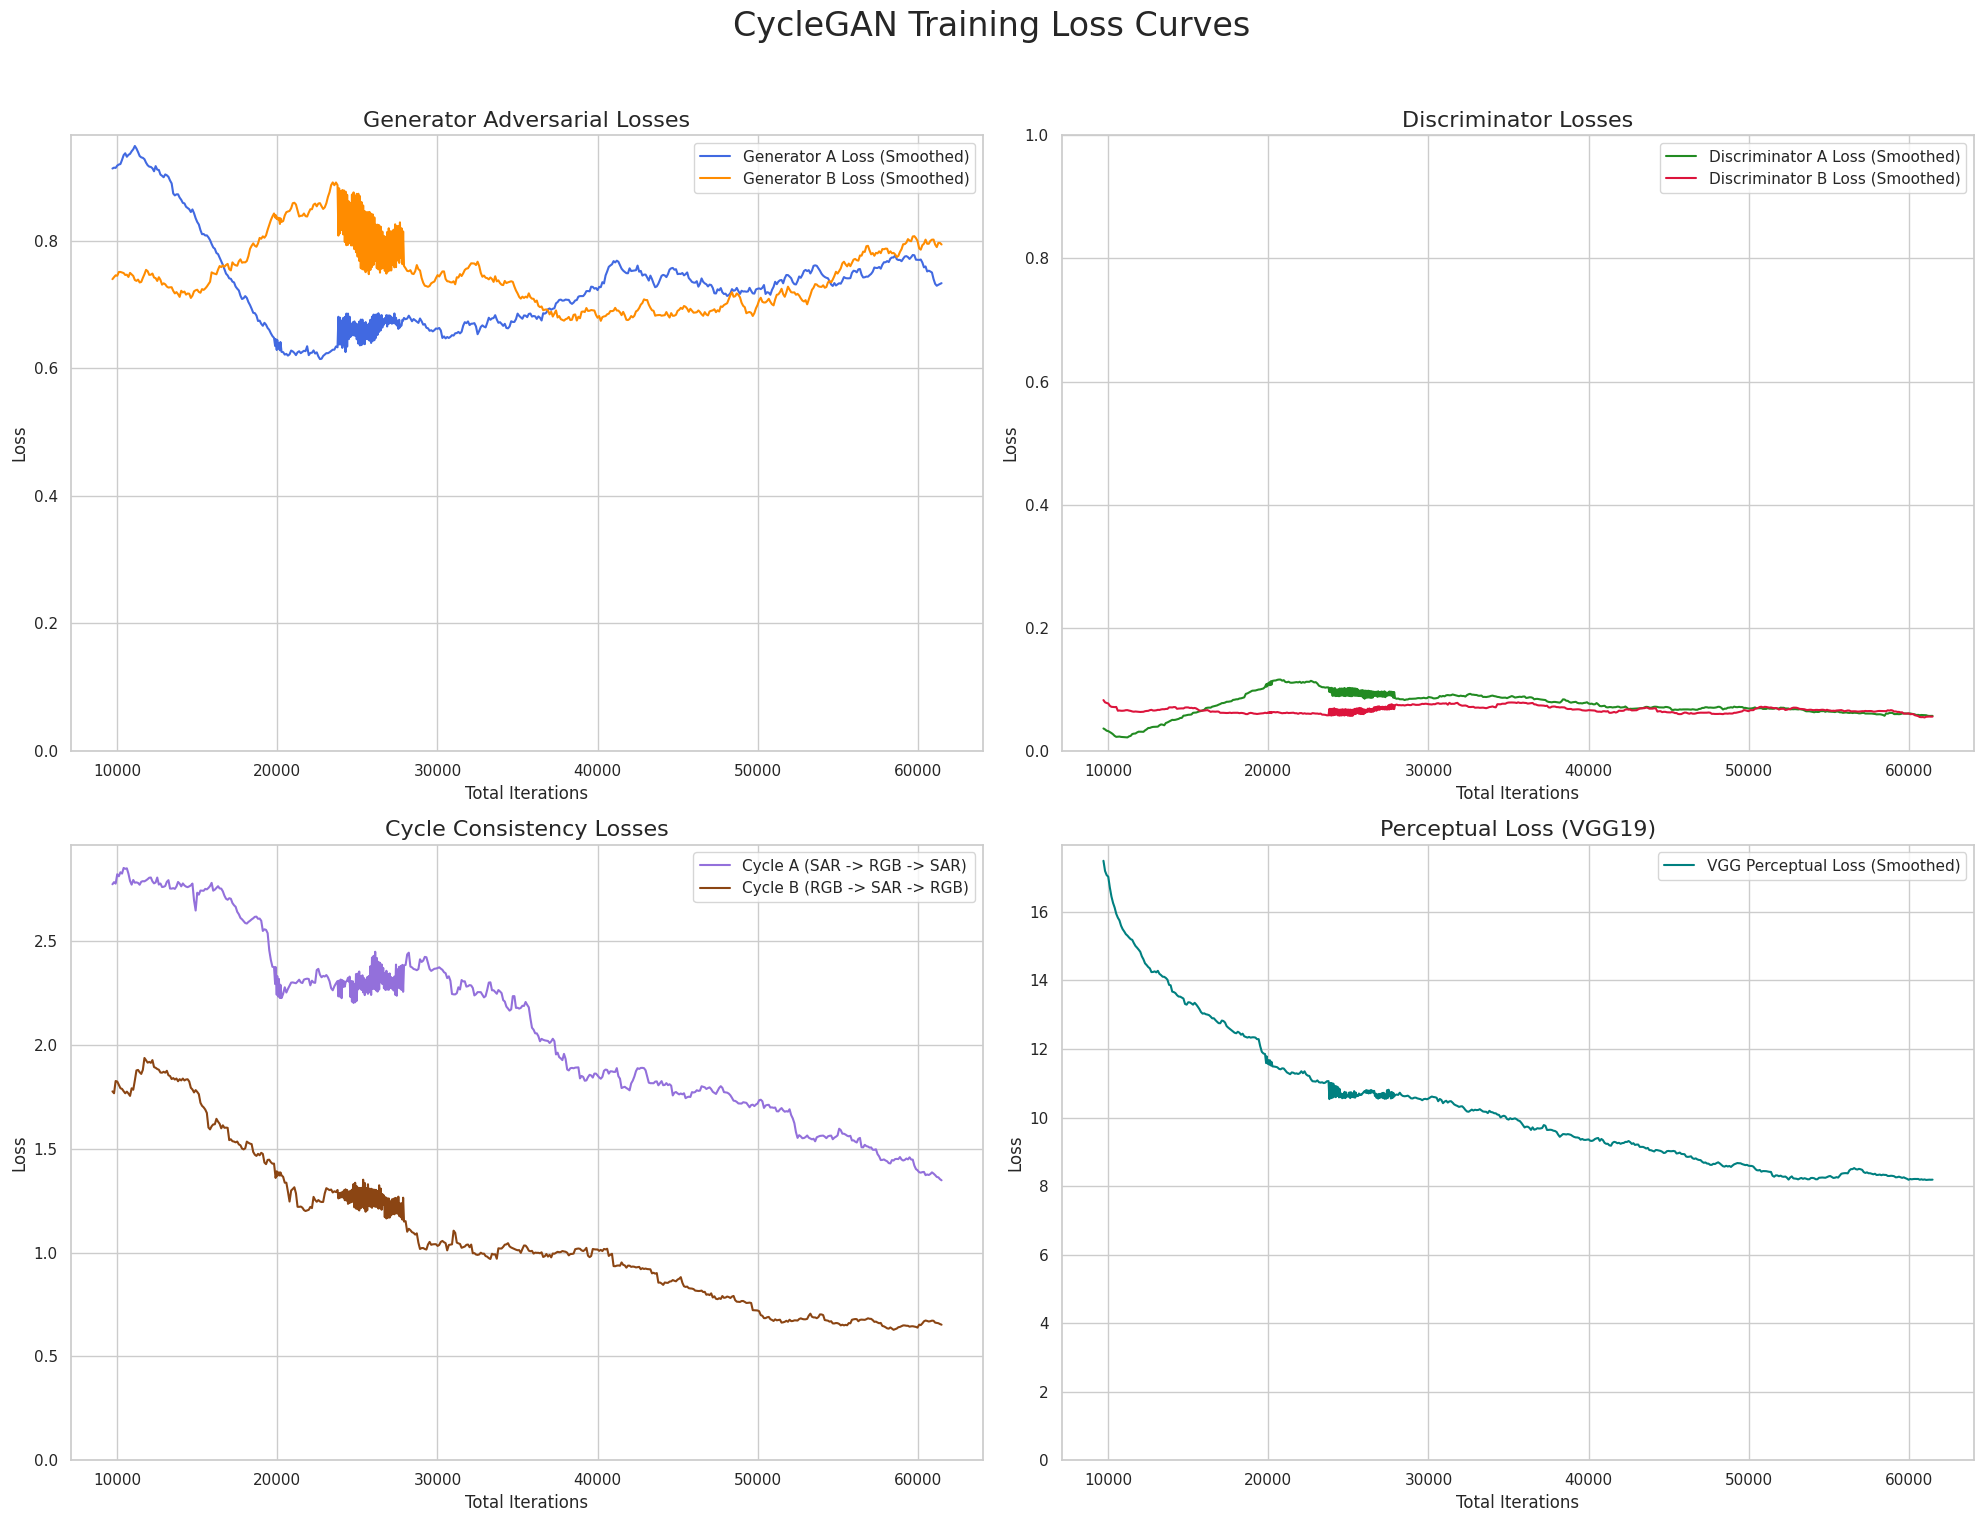

In [2]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def parse_loss_log(log_file_path):
    """
    Parses the CycleGAN loss log file into a pandas DataFrame.

    Args:
        log_file_path (str): The path to the loss_log.txt file.

    Returns:
        pandas.DataFrame: A DataFrame containing the parsed loss values.
    """
    # Regular expression to capture all key-value pairs from a log line
    log_pattern = re.compile(
        r"epoch: (?P<epoch>\d+), iters: (?P<iters>\d+).*?"
        r"D_A: (?P<D_A>\d+\.\d+)\s+"
        r"G_A: (?P<G_A>\d+\.\d+)\s+"
        r"cycle_A: (?P<cycle_A>\d+\.\d+)\s+"
        r"idt_A: (?P<idt_A>\d+\.\d+)\s+"
        r"D_B: (?P<D_B>\d+\.\d+)\s+"
        r"G_B: (?P<G_B>\d+\.\d+)\s+"
        r"cycle_B: (?P<cycle_B>\d+\.\d+)\s+"
        r"idt_B: (?P<idt_B>\d+\.\d+)\s+"
        r"perceptual: (?P<perceptual>\d+\.\d+)"
    )

    records = []
    try:
        with open(log_file_path, 'r') as f:
            for line in f:
                match = log_pattern.search(line)
                if match:
                    records.append(match.groupdict())
    except FileNotFoundError:
        print(f"ERROR: Log file not found at '{log_file_path}'. Please check the path.")
        return None

    if not records:
        print("ERROR: No data was parsed. The log file might be empty or in an unexpected format.")
        return None

    # Convert records to a DataFrame and cast columns to numeric types
    df = pd.DataFrame(records)
    for col in df.columns:
        df[col] = pd.to_numeric(df[col])

    # --- Create a continuous 'total_iters' column for a smooth x-axis ---
    # Find the number of iterations per epoch (assumes it's consistent)
    iters_per_epoch = df.groupby('epoch')['iters'].max().max()
    df['total_iters'] = (df['epoch'] - 1) * iters_per_epoch + df['iters']

    return df

def plot_loss_curves(df, smoothing_window=50):
    """
    Generates and displays beautiful, smoothed plots of the training loss curves.

    Args:
        df (pandas.DataFrame): The DataFrame containing the parsed loss data.
        smoothing_window (int): The window size for the rolling average to smooth curves.
    """
    if df is None or df.empty:
        print("Cannot plot an empty DataFrame.")
        return

    # Set plot style
    sns.set_theme(style="whitegrid")

    # Create a 2x2 subplot grid
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('CycleGAN Training Loss Curves', fontsize=24, y=0.95)

    # --- Plot 1: Generator Losses (G_A, G_B) ---
    ax1 = axes[0, 0]
    sns.lineplot(data=df, x='total_iters', y=df['G_A'].rolling(smoothing_window).mean(), ax=ax1, label='Generator A Loss (Smoothed)', color='royalblue')
    sns.lineplot(data=df, x='total_iters', y=df['G_B'].rolling(smoothing_window).mean(), ax=ax1, label='Generator B Loss (Smoothed)', color='darkorange')
    ax1.set_title('Generator Adversarial Losses', fontsize=16)
    ax1.set_xlabel('Total Iterations', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend()
    ax1.set_ylim(bottom=0)

    # --- Plot 2: Discriminator Losses (D_A, D_B) ---
    ax2 = axes[0, 1]
    sns.lineplot(data=df, x='total_iters', y=df['D_A'].rolling(smoothing_window).mean(), ax=ax2, label='Discriminator A Loss (Smoothed)', color='forestgreen')
    sns.lineplot(data=df, x='total_iters', y=df['D_B'].rolling(smoothing_window).mean(), ax=ax2, label='Discriminator B Loss (Smoothed)', color='crimson')
    ax2.set_title('Discriminator Losses', fontsize=16)
    ax2.set_xlabel('Total Iterations', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend()
    ax2.set_ylim(0, 1.0) # Discriminator loss often hovers around 0.5

    # --- Plot 3: Cycle Consistency Losses ---
    ax3 = axes[1, 0]
    sns.lineplot(data=df, x='total_iters', y=df['cycle_A'].rolling(smoothing_window).mean(), ax=ax3, label='Cycle A (SAR -> RGB -> SAR)', color='mediumpurple')
    sns.lineplot(data=df, x='total_iters', y=df['cycle_B'].rolling(smoothing_window).mean(), ax=ax3, label='Cycle B (RGB -> SAR -> RGB)', color='saddlebrown')
    ax3.set_title('Cycle Consistency Losses', fontsize=16)
    ax3.set_xlabel('Total Iterations', fontsize=12)
    ax3.set_ylabel('Loss', fontsize=12)
    ax3.legend()
    ax3.set_ylim(bottom=0)

    # --- Plot 4: Perceptual Loss ---
    ax4 = axes[1, 1]
    sns.lineplot(data=df, x='total_iters', y=df['perceptual'].rolling(smoothing_window).mean(), ax=ax4, label='VGG Perceptual Loss (Smoothed)', color='teal')
    ax4.set_title('Perceptual Loss (VGG19)', fontsize=16)
    ax4.set_xlabel('Total Iterations', fontsize=12)
    ax4.set_ylabel('Loss', fontsize=12)
    ax4.legend()
    ax4.set_ylim(bottom=0)

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

# --- Main Execution ---
if __name__ == '__main__':
    # --- CONFIGURATION ---
    # The path to your training log file.
    LOG_FILE_PATH = '/content/drive/MyDrive/cyclegans_new/pytorch-CycleGAN-and-pix2pix/checkpoints/sar2rgb_perceptual/loss_log.txt'
    # --- END CONFIGURATION ---

    # 1. Parse the log file into a DataFrame
    loss_df = parse_loss_log(LOG_FILE_PATH)

    # 2. Generate and display the plots
    if loss_df is not None:
        print(f"Successfully parsed {len(loss_df)} records from the log file.")
        plot_loss_curves(loss_df, smoothing_window=100)



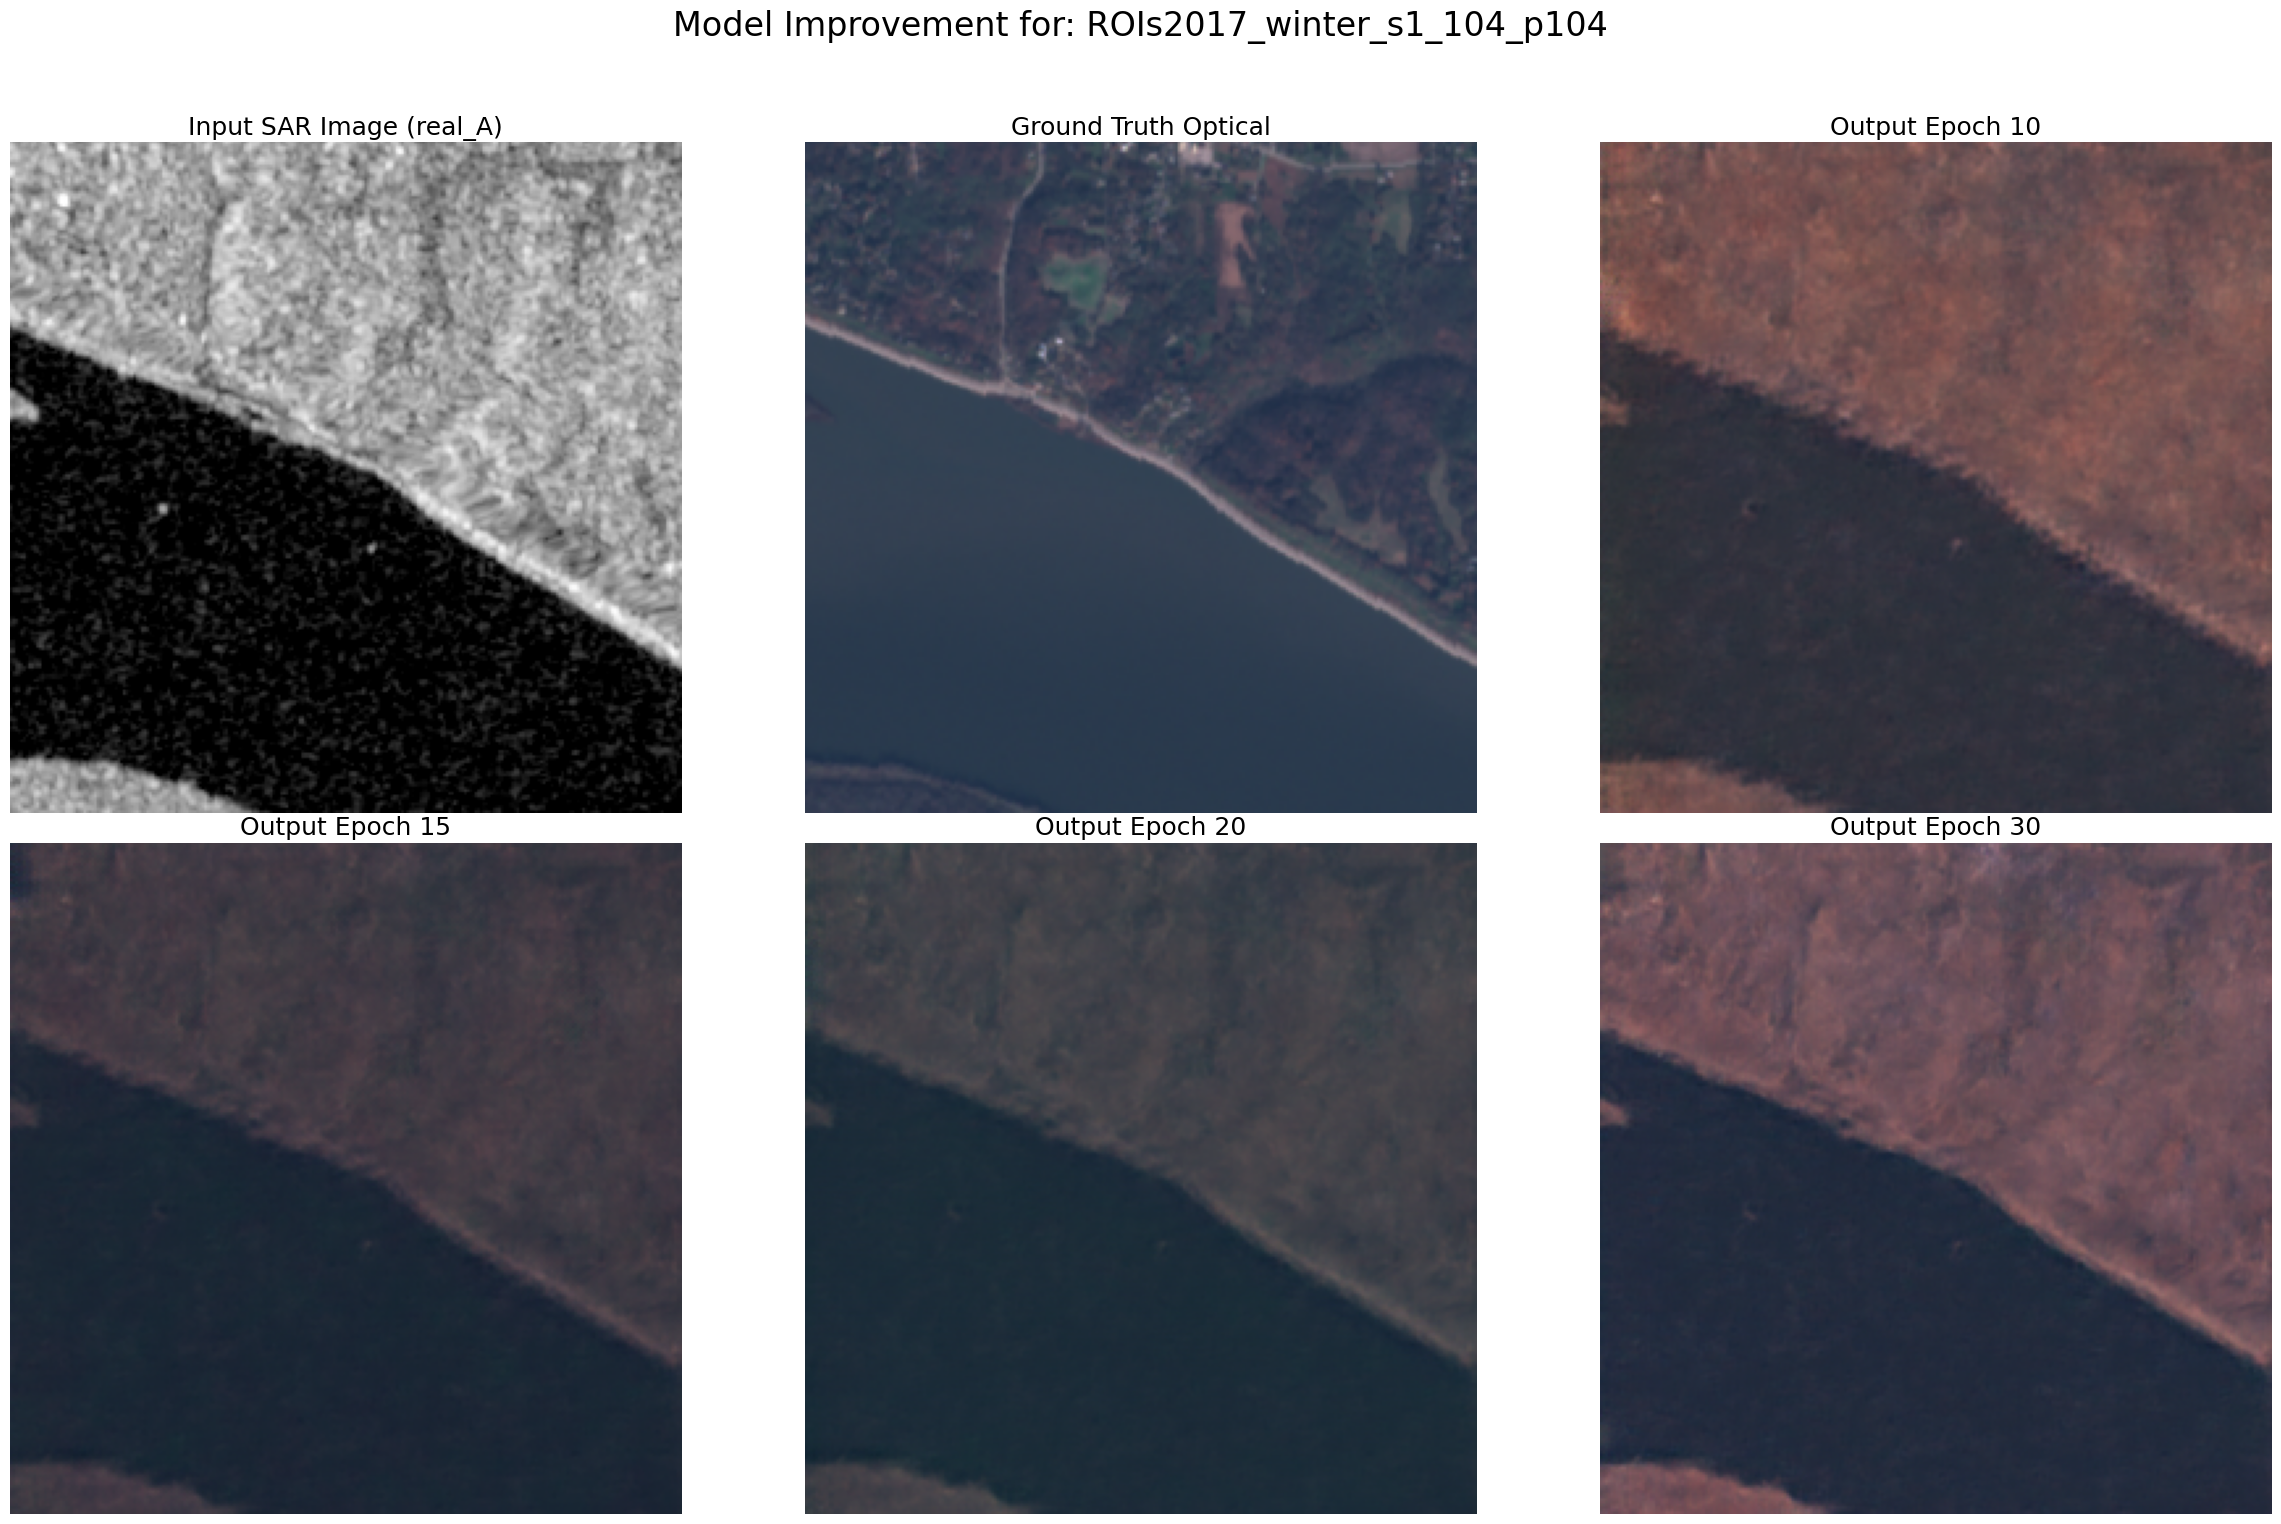

In [36]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import numpy as np

# --- ⚙️ CONFIGURATION ---
# 1. The name of your training experiment.
EXPERIMENT_NAME = 'sar2rgb_perceptual'

# 2. The base name of the image you want to see.
IMAGE_BASENAME = 'ROIs2017_winter_s1_104_p104'

# 3. The four epochs you want to compare. Use 'latest' for the most recent.
EPOCHS_TO_COMPARE = [10, 15, 20, 30]

# 4. The path to your preprocessed ground truth data.
GROUND_TRUTH_DIR = "/content/drive/MyDrive/cyclegans_new/pytorch-CycleGAN-and-pix2pix/preprocessed_test_data/eo_ground_truth_rgb"
# --- END CONFIGURATION ---


# --- Path Setup ---
results_dir = f"./results/{EXPERIMENT_NAME}/"

# Path for the input SAR image (only needs one epoch to exist)
real_A_path = os.path.join(results_dir, f"test_{EPOCHS_TO_COMPARE[0]}", "images", f"{IMAGE_BASENAME}_real_A.png")

# Create a list of paths for the generated images from each epoch
fake_B_paths = [
    os.path.join(results_dir, f"test_{epoch}", "images", f"{IMAGE_BASENAME}_fake_B.png")
    for epoch in EPOCHS_TO_COMPARE
]

# Construct ground truth path
gt_fname = IMAGE_BASENAME.replace('_s1_', '_s2_') + '.npy'
ground_truth_path = os.path.join(GROUND_TRUTH_DIR, gt_fname)


# --- Visualization ---
# Create a 2x3 grid for 6 images
fig, axes = plt.subplots(2, 3, figsize=(24, 16))
fig.suptitle(f'Model Improvement for: {IMAGE_BASENAME}', fontsize=24)

# Flatten the axes array for easier iteration
ax_flat = axes.flatten()

try:
    # --- Plot 1: Input SAR (real_A) ---
    img_real_A = mpimg.imread(real_A_path)
    ax_flat[0].imshow(img_real_A)
    ax_flat[0].set_title('Input SAR Image (real_A)', fontsize=18)
    ax_flat[0].axis('off')

    # --- Plot 2: Ground Truth Optical (real_B) ---
    gt_npy = np.load(ground_truth_path)
    gt_image = ((gt_npy + 1) / 2.0 * 255.0).astype(np.uint8) # De-normalize for display
    ax_flat[1].imshow(gt_image)
    ax_flat[1].set_title('Ground Truth Optical', fontsize=18)
    ax_flat[1].axis('off')

    # --- Plots 3-6: Generated Outputs from each Epoch ---
    for i, epoch in enumerate(EPOCHS_TO_COMPARE):
        ax_index = i + 2  # Start plotting from the 3rd subplot
        img_fake_B = mpimg.imread(fake_B_paths[i])
        ax_flat[ax_index].imshow(img_fake_B)
        ax_flat[ax_index].set_title(f'Output Epoch {epoch}', fontsize=18)
        ax_flat[ax_index].axis('off')

except FileNotFoundError as e:
    print(f"❌ Error: Could not find an image file. Please check your configuration.")
    print(f"Missing file: {e.filename}")
    for ax in ax_flat:
        ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
